Imports

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the [MIT License] (we sincerely appreciate all attributions and readily accept most contributions, but please don’t hold us liable).

In [1]:
!pip install vaderSentiment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
plt.rcParams["figure.figsize"] = (10, 5)



Chargement du fichier

In [3]:
df = pd.read_csv("../content/tinder_reviews_2025.csv")
print(df.shape)
df.head()

(28534, 11)


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,2b6a39f7-32ab-4585-bcff-992a8fa23426,Asadulla Khan,https://play-lh.googleusercontent.com/a/ACg8oc...,Too many scams here — people put WhatsApp numb...,1,0,16.28.0,2025-11-06 19:39:44,NaN,NaN,16.28.0
1,3a853486-df17-4ea2-a88b-98fb075860b9,Zenaa Mohammad,https://play-lh.googleusercontent.com/a/ACg8oc...,"still trying to get to know it better, but it ...",2,0,16.28.0,2025-11-06 19:32:54,NaN,NaN,16.28.0
2,b782128c-c204-4e76-945b-7149df005117,Frieda Mukunisha,https://play-lh.googleusercontent.com/a/ACg8oc...,excellent,5,0,NaN,2025-11-06 19:26:40,NaN,NaN,NaN
3,5e95532a-c6d3-45bf-afb2-2128405047d5,4464,https://play-lh.googleusercontent.com/a/ACg8oc...,lot of fake profiles,1,0,16.28.0,2025-11-06 19:22:07,NaN,NaN,16.28.0
4,b8603e49-03a7-4cda-a43e-a83bdb7f517e,Max Carpendale,https://play-lh.googleusercontent.com/a-/ALV-U...,Tried to activate premium. Account got deleted...,1,0,16.28.0,2025-11-06 18:58:09,NaN,NaN,16.28.0


Nettoyage du texte (on ajoute une colonne clean_text en sortie qui correspond à la colonne content mais nettoyée)

In [4]:
url_re = re.compile(r"https?://\S+|www\.\S+")
html_re = re.compile(r"<.*?>")

def clean_text(s):
    s = str(s).lower() #on met en minuscule
    s = url_re.sub(" ", s) #suppression des url
    s = html_re.sub(" ", s)#supression des balises html
    s = re.sub(r"[^a-zàâäéèêëîïôöùûüç0-9\s']", " ", s)  # On garde seulement les caractères suivant, à voir si on supprime les accents si on garde seulement des commentaires anglais
    s = re.sub(r"\s+", " ", s).strip() #Pour eviter les espaces consecutifs
    return s

df = df.dropna(subset=["content"])
df["clean_text"] = df["content"].apply(clean_text)

df[["content", "clean_text"]].head(10)


,content,clean_text
0,Too many scams here — people put WhatsApp numb...,too many scams here people put whatsapp number...
1,"still trying to get to know it better, but it ...",still trying to get to know it better but it i...
2,excellent,excellent
3,lot of fake profiles,lot of fake profiles
4,Tried to activate premium. Account got deleted...,tried to activate premium account got deleted ...
5,"Tinder and its parent company, use explotive a...",tinder and its parent company use explotive al...
6,good,good
7,paisa loot app???.........,paisa loot app
8,Cool app,cool app
9,easy to find a match,easy to find a match


#Analyse des sentiments sur l'année 2025

In [5]:

analyzer = SentimentIntensityAnalyzer()
df["sentiment_score"] = df["clean_text"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

# --- Labelisation ---
def to_label(score):
    if score >= 0.05: return "positif"
    if score <= -0.05: return "négatif"
    return "neutre"

df["sentiment_label"] = df["sentiment_score"].apply(to_label)

df["sentiment_label"].value_counts()

,count
sentiment_label,
positif,13174
négatif,10641
neutre,4719


Répartition des sentiments

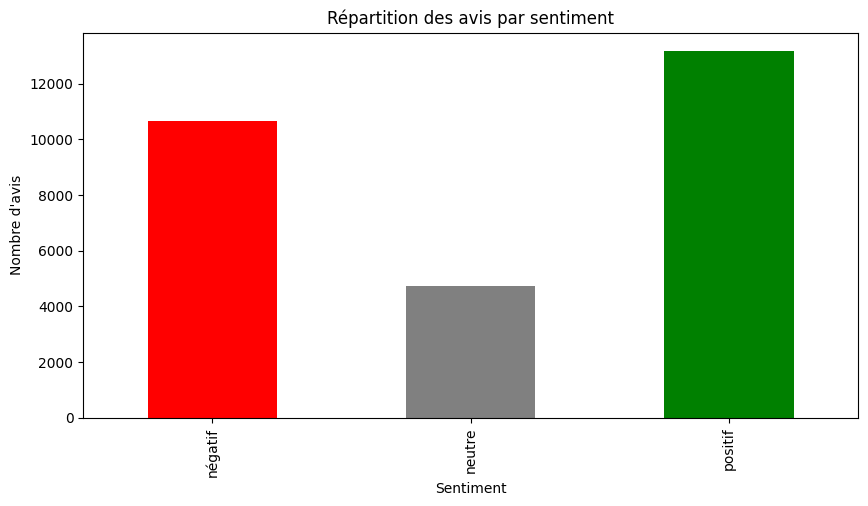

In [6]:
sent_counts = df["sentiment_label"].value_counts().reindex(["négatif","neutre","positif"]).fillna(0)

sent_counts.plot(kind="bar", color=["red","gray","green"])
plt.title("Répartition des avis par sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Nombre d'avis")
plt.show()


Calcul des pourcentages

pourcentage par sentiment :
sentiment_label
négatif    37.29 %
neutre     16.54 %
positif    46.17 %
Name: proportion, dtype: object


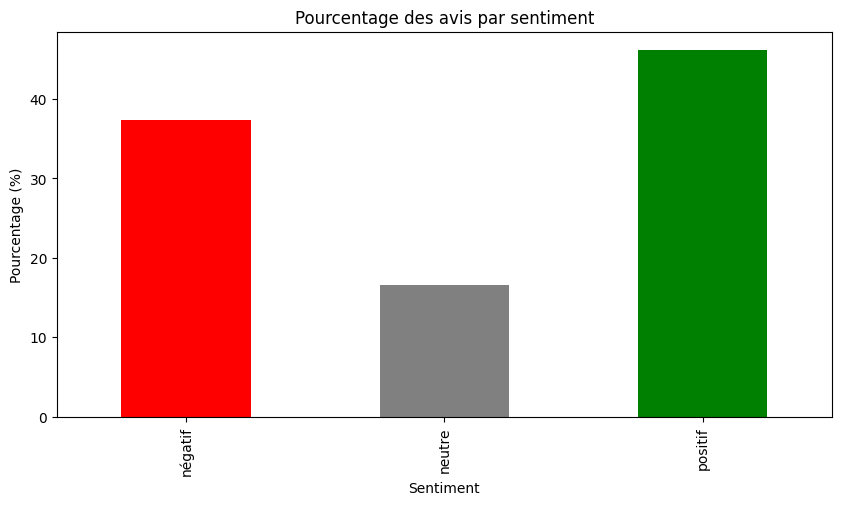

In [7]:
sent_percent = df["sentiment_label"].value_counts(normalize=True) * 100
sent_percent = sent_percent.reindex(["négatif","neutre","positif"]).fillna(0)

print("pourcentage par sentiment :")
print(sent_percent.round(2).astype(str) + " %")

sent_percent.plot(kind="bar", color=["red","gray","green"])
plt.title("Pourcentage des avis par sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Pourcentage (%)")
plt.show()


Sentiment moyen par nombre d'étoiles (en sachant que le score va de -1 à 1)

In [8]:
grouped = df.groupby("score")
mean_sentiment = grouped["sentiment_score"].mean()
table = mean_sentiment.reset_index()
table.columns = ["Nombre d'étoiles", "Sentiment moyen"]
print(table)

   Nombre d'étoiles  Sentiment moyen
0                 1        -0.210199
1                 2        -0.000536
2                 3         0.188769
3                 4         0.391612
4                 5         0.443066


Préparation des mois + agrégats

In [9]:
df["at"] = pd.to_datetime(df["at"], errors="coerce") #conversion des dates qui sont en format texte en format datetime
df["month"] = df["at"].dt.to_period("M") #converstion de chaque date en période mensuelle pour regrouper chaque avis pour un mois

Senztiment moyen par mois

In [10]:
monthly_sentiment = (
    df.groupby("month")["sentiment_score"]
      .mean()
      .rename("sentiment_moyen_mois"))

Note moyenne par mois

In [11]:
monthly_score = (
    df.groupby("month")["score"]
      .mean()
      .rename("note_moyenne_mois")
)

Ajout de la colonne sentiment_moyen_mois" à chaque ligne

In [12]:
df = df.join(monthly_sentiment, on="month")

Affichage de l'évolution du sentiment et de la note par mois des avis

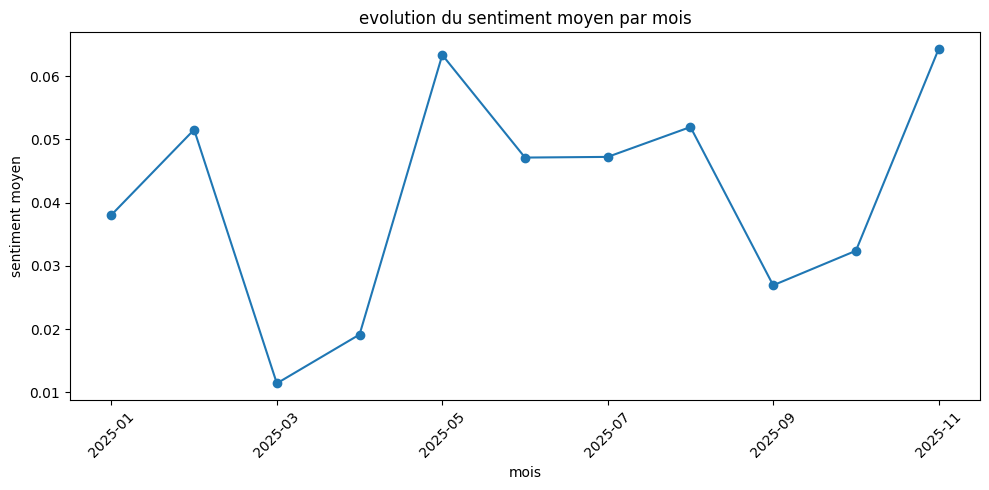

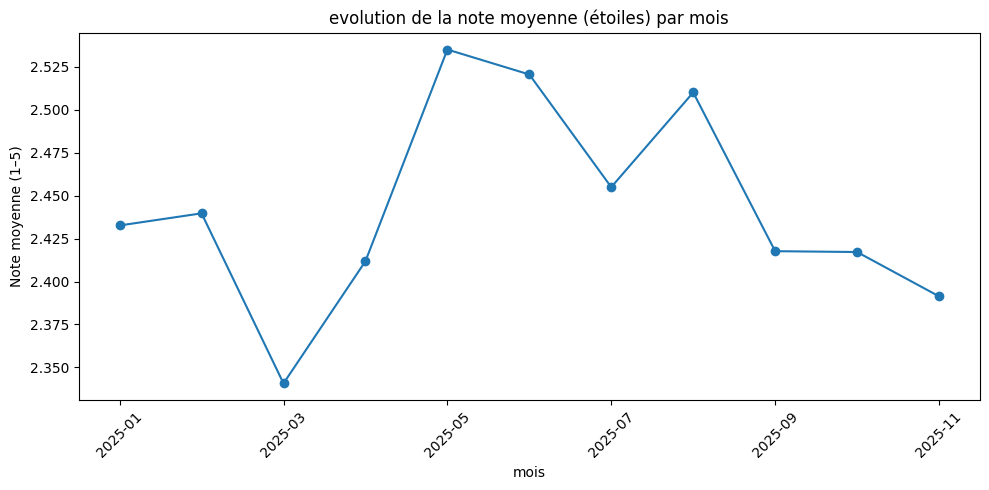

In [13]:
import matplotlib.pyplot as plt

sent_series = monthly_sentiment.copy()
sent_series.index = sent_series.index.astype(str)

score_series = monthly_score.copy()
score_series.index = score_series.index.astype(str)

# evolution du sentiment moyen
plt.figure()
sent_series.plot(marker="o")
plt.title("evolution du sentiment moyen par mois")
plt.xlabel("mois")
plt.ylabel("sentiment moyen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#evolution de la note moyenne
plt.figure()
score_series.plot(marker="o")
plt.title("evolution de la note moyenne (étoiles) par mois")
plt.xlabel("mois")
plt.ylabel("Note moyenne (1–5)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
